In [0]:
#List of all the libaries that will be used
import tensorflow as tf
import string
import numpy as np
from PIL import Image
from os import listdir
from pickle import dump, load
from numpy import array
from numpy import argmax
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import corpus_bleu
from keras.utils import plot_model


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Extract features from each photo in the directory
def extract_features(directory):
    
    model = VGG16()

    # Removing the last layer from the loaded model because only the features are reqired not the classification 
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    
    print(model.summary())

    features = dict()

    for name in listdir(directory):

        filename = directory + '/' + name
        
        image = load_img(filename, target_size=(224, 224))
        
        # Converting the image pixels into a numpy array
        image = img_to_array(image)
        
        # Reshaping data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)

        # Getting features of an image
        feature = model.predict(image, verbose=0)
        
        # Getting the image name
        image_id = name.split('.')[0]
        
        features[image_id] = feature
        
    return features

In [5]:
directory = '/content/drive/My Drive/Colab Notebooks/Image-Captioning/input/Flickr8k_Dataset/Flicker8k_Dataset'

features = extract_features(directory)

print('Extracted Features: ', len(features))











Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128) 

In [6]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload 
# Dumping the features in a pickle file to use later on 
dump(features, open('features.pkl', 'wb'))
uploaded = drive.CreateFile({'title': 'features.pkl'})
uploaded.SetContentString('Sample upload file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 18Qi2ikwaOVmk9g27R8bJs-Ts9JCeS4V7


In [0]:
#function to load a file
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [8]:
filename = '/content/drive/My Drive/Colab Notebooks/Image-Captioning/input/Flickr8k_text/Flickr8k.token.txt'

doc = load_doc(filename)

print(doc[:200])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A lit


In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

path_test = '/content/drive/My Drive/Colab Notebooks/Image-Captioning/input/Flickr8k_Dataset/Flicker8k_Dataset/101654506_8eb26cfb60.jpg'
path_out = load_image(path_test)
test_doc = path_out
print(test_doc[:1])

(<tf.Tensor 'sub:0' shape=(299, 299, 3) dtype=float32>,)


In [0]:
def photo_to_description_mapping(descriptions):
    
    description_mapping = dict()

    for line in descriptions.split('\n'):
        
        words = line.split()
        
        if len(line)<2:
            continue
            
        # The first word is the image_id and the rest are the part of the description of that image
        image_id, image_description = words[0], words[1:]
        image_id = image_id.split('.')[0]
        
        image_description = ' '.join(image_description)
        
        if image_id not in description_mapping:
            description_mapping[image_id] = list()

        description_mapping[image_id].append(image_description)
    
    return description_mapping

In [11]:
descriptions = photo_to_description_mapping(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [0]:
def clean_descriptions(description_mapping):
    
    table = str.maketrans('','', string.punctuation)
    
    for key, descriptions in description_mapping.items():
        for i in range(len(descriptions)):
            description = descriptions[i]
            description = description.split()
            description = [word.lower() for word in description]
            description = [word.translate(table) for word in description]
            description = [word for word in description if len(word)>1]
            description = [word for word in description if word.isalpha()]
            
            # Converting the description back to string and overwriting in the descriptions list
            descriptions[i] = ' '.join(description)

In [0]:
clean_descriptions(descriptions)

In [0]:
# Converting the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # Build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    
    return all_desc

In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [16]:
# Summarizing the vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# Saving to the file
save_descriptions(descriptions, 'descriptions.txt')

Vocabulary Size: 8763


In [0]:
# Function for loading a file into memory
def load_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Function for loading a pre-defined list of photo identifiers
def load_photo_identifiers(filename):
    
    file = load_file(filename)

    photos = list()
    
    # Traversing the file one line at a time
    for line in file.split('\n'):
        if len(line) < 1:
            continue
    
        identifier = line.split('.')[0]
        
        photos.append(identifier)
    
    return set(photos)

def load_clean_descriptions(filename, photos):
    
    file = load_file(filename)
    descriptions = dict()
    
    for line in file.split('\n'):
        words = line.split()
        
        image_id, image_description = words[0], words[1:]
        
        if image_id in photos:
            #creating list of description if needed
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            desc = 'startseq ' + ' '.join(image_description) + ' endseq'
            descriptions[image_id].append(desc)
            
    return descriptions

# function to load the photo features created using the VGG16 model
def load_photo_features(filename, photos):
    
    all_features = load(open(filename, 'rb'))
    
    features = {k: all_features[k] for k in photos}
    
    return features

In [18]:
filename = '/content/drive/My Drive/Colab Notebooks/Image-Captioning/input/Flickr8k_text/Flickr_8k.trainImages.txt'

train = load_photo_identifiers(filename)
print('Dataset: ',len(train))

Dataset:  6000


In [19]:
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))


Descriptions: train= 6000


In [0]:
#use the features.pkl that was saved above
train_features = load_photo_features('features.pkl', train)

In [0]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [22]:
tokenizer = create_tokenizer(train_descriptions)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)

Vocabulary Size:  7579


In [0]:
#calculated the length of description with most words
def max_lengthTEMP(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [0]:
#data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            photo = photos[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, photo)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
    
        for i in range(1, len(seq)):
            
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [0]:
# define the captioning model
def define_model(vocab_size, max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [0]:
filename = '/content/drive/My Drive/Colab Notebooks/Image-Captioning/input/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))

tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:', vocab_size)

max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ', max_length)

train_features = load_photo_features('features.pkl', train)
print('Photos: train=', len(train_features))



In [33]:

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
train_features = load_photo_features('features.pkl', train)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model.h5')

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 34, 256)      1940224     input_9[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 4096)         0           input_8[0][0]                    
____________________________________________________________________________________________

KeyError: ignored

In [0]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):

    in_text = 'startseq'

    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        prob = model.predict([photo,sequence], verbose=0)
        prob = argmax(prob)
       
        word = word_for_id(prob, tokenizer)
        
        if word is None:
            break
        
        in_text += ' ' + word
        
        if word == 'endseq':
            break
    return in_text

#the below function evaluates the the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        prediction = generate_desc(model, tokenizer, photos[key], max_length)
        actual_desc = [d.split() for d in desc_list]
        actual.append(actual_desc)
        predicted.append(prediction.split())

    print('BLEU-1: ', corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: ', corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: ', corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: ', corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [0]:
filename = '/content/drive/My Drive/Colab Notebooks/Image-Captioning/input/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)
max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ,', max_length)

filename = '/content/drive/My Drive/Colab Notebooks/Image-Captioning/input/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_photo_identifiers(filename)
print('Dataset: ', len(test))
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=', len(test_descriptions))
test_features = load_photo_features('features.pkl', test)
print('Photos: test=', len(test_features))

filename = 'model_12.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

In [37]:
filename = '/content/drive/My Drive/Colab Notebooks/Image-Captioning/input/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset:  6000
Descriptions: train= 6000


In [0]:
def extract_features(filename):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_cap(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

tokenizer = load(open('tokenizer.pkl', 'rb'))
max_length = 34

startseq man in black shirt is riding on surfboard endseq


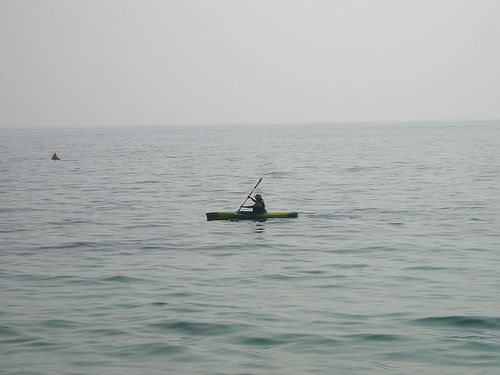

In [45]:
#test the caption generator with an image
model = load_model('/content/drive/My Drive/Colab Notebooks/Image-Captioning/model.h5')
path = '/content/drive/My Drive/Colab Notebooks/test.jpg'
photo = extract_features(path)

description = generate_cap(model, tokenizer, photo, max_length)

print(description)

Image.open(path)